# Keeper tutorial

The primary data structure used in `netflow` is called a `Keeper`. It is used to load, store, manipulate and save data for a set of observations. In particular, there are several specific types of keepers:

- `DataKeeper` : handles feature data
- `DistanceKeeper` : handles pairwise-observation distances (also used to handle pairwise observation similarities)
- `GraphKeeper` : handles graphs (networks)

Interacting with `netflow` will primarily entail making use of the predomenent `Keeper`, which implicitly makes use of the aforementioned specific keeper classes. This tutorial therefore focuses on the `Keeper` class, please see the documentation for more detail on the other Keeper classes. 

Data is organized in the `Keeper` class via the following attributes:

- `self.oudir` : (directory path) : Path to directory where results will be saved.
    - If not provided, no results can be saved.
- `self.observation_labels` : (`list`) Observation labels are kept consistent across all feature data, distances and similarities.
- `self.data` : (`DataKeeper`) Used to handle all feature data.
- `self.distances` : (`DistanceKeeper`) Used to handle all observation-pairwise distances.
- `self.similarities` : (`DistanceKeeper`) Used to handle all observation-pairwise similarities.
- `self.graphs` : (`GraphKeeper`) Used to handle all graphs.
- `self.misc` : (`dict`) Used to handle any miscellaneous data. 
    - Caution should be taken as observation labels and/or ordering of data stored in `self.misc` may not be consistent with the observations as tracked by the `Keeper`.

We will now walk through some use-cases of how to make use of the `Keeper` class.

First, import the necessary packages:

# Load libraries

In [36]:
import pathlib
import sys

from collections import defaultdict as ddict
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sc_sparse
from tqdm import tqdm

If ``netflow`` has not been installed, add the path to the library:

In [37]:
sys.path.insert(0, pathlib.Path(pathlib.Path('.').absolute()).parents[3].resolve().as_posix())
# sys.path.insert(0, pathlib.Path(pathlib.Path('.').absolute()).parents[0].resolve().as_posix())

From the ``netflow`` package, we load the following modules:
 - The ``InfoNet`` class is used to compute 1-hop neighborhood distances
 - The ``Keeper`` class is used to store and manipulate data/results

In [38]:
import netflow as nf

# from netflow.keepers import keeper 

# Set up directories

In [39]:
MAIN_DIR = pathlib.Path('.').absolute()

Paths to where data is stored:

In [40]:
DATA_DIR = MAIN_DIR / 'example_data' / 'breast_tcga'

RNA_FNAME = DATA_DIR / 'rna_606.txt'
E_RNA_FNAME = DATA_DIR / 'edgelist_hprd_rna_606.txt'

CNA_FNAME = DATA_DIR / 'cna_606.txt'
E_CNA_FNAME = DATA_DIR / 'edgelist_hprd_cna_606.txt'

METH_FNAME = DATA_DIR / 'methylation_606.txt'
E_METH_FNAME = DATA_DIR / 'edgelist_hprd_methylation_606.txt'

CLIN_FNAME = DATA_DIR / 'clin_606.txt'

Directory where output should be saved:

In [41]:
OUT_DIR = MAIN_DIR / 'example_data' / 'results_netflow_breast_tcga'

# Load data

In [42]:
# We first load example TCGA breast cancer data that will be used to demonstrate how data can be loaded into the `Keeper`.

# Sample inclusion criteria (n=606):
# - Restricted to 
#     - Primary samples
#     - Cancer type: Breast Cancer
#     - Detailed cancer type: Breast Invasive Ductal Carcinoma (IDC) or  Breast Invasive Lobular Carcinoma (ILC)
# - Has reported overall survival status
# - Overall survival > 3.5 months (Figure 1)    
#     <!-- - <img src="attachment:6fc3253c-59fc-4cd5-b9d3-e407edd6a484.png" alt="OS histogram" width="200"/> -->
#     <!-- - <img src="BC_overall_survival_hist.png" alt="OS historgram" width="200"/> -->
#     ![OS histogram](BC_overall_survival_hist.png)

#     - distribution of age of patients excluded is similar to distribution of the age of all samples (Figure 2)
    
#     ![age_histogram](BC_age_histogram.png)
#     <!-- <img src="BC_age_histogram.png" alt="age histogram" width="200"/> -->
#     <!-- <img src="attachment:822ef528-aa96-48a6-80c5-12710e35b110.png" alt="age histogram" width="200"/> -->
# - Has reported PAM50 subtype
# - Has RNA, CNA and methylation data

# - Feature data:
#     - RNA (7,148 genes)
#         - Remove genes that have zero expression in at least 20% (=121) of samples
#         - When multiple Entrez IDs map to the same gene, use the sum
#         - Restrict to largest connected component of genes in HPRD
#     - CNA (8,763 genes)
#         - When multiple Entrez IDs map to the same gene, select the more extreme value (i.e., in absolute value). If the absolute values are the same, select the loss.
#         - Restrict to largest connected component of genes in HPRD
#         - Translate from [-2, 2] -> [0, 4]
#     - methylation (7,969 genes)        
#         - Missing rate is at most 5.12% - used nearest-neighbor imputation computed in Python using the scikit-learn `KNNImputer` with default parameters except `weights=“distance”`.
#         - When multiple Entrez IDs map to the same gene, select the max.
#         - Restrict to largest connected component of genes in HPRD
# - Network edgelists (derived from HPRD):
#     - RNA edgelist (7,148 nodes and 27,498 edges)
#     - CNA edgelist (8,763 nodes and 34,906 edges)
#     - methylation edgelist (7,969 nodes and 31,112 edges)

In [52]:
print(*[k.name for k in (pathlib.Path('.').absolute() / '../../').iterdir()], sep='\n')



index.rst
tutorial
.DS_Store
references.bib
_templates
conf.py
index.rst~
_static
conf.py~
references.rst
overview
reference
building


We first load example TCGA breast cancer data that will be used to demonstrate how data can be loaded into the `Keeper`.

Sample inclusion criteria (n=606):
- Restricted to 
    - Primary samples
    - Cancer type: Breast Cancer
    - Detailed cancer type: Breast Invasive Ductal Carcinoma (IDC) or  Breast Invasive Lobular Carcinoma (ILC)
- Has reported overall survival status
- Overall survival > 3.5 months (Figure 1)    
    <!-- - 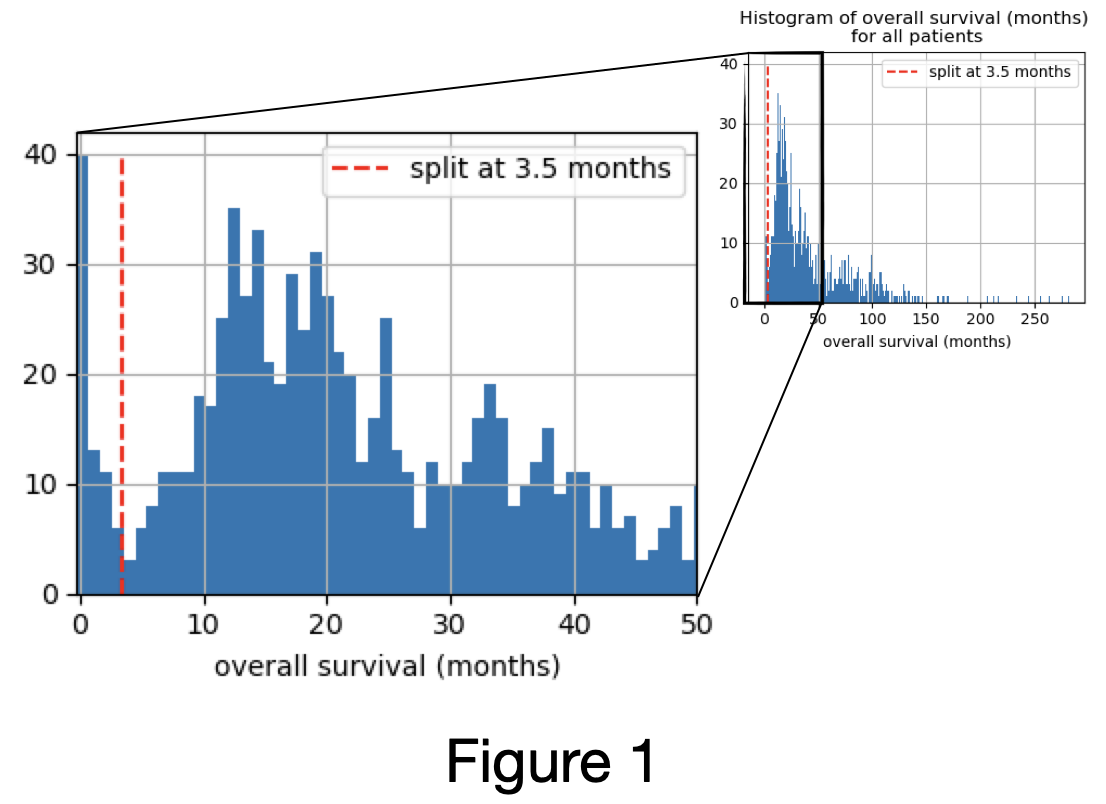 -->
    <!-- - <img src="BC_overall_survival_hist.png" alt="OS historgram" width="200"/> -->
    ![OS histogram](BC_overall_survival_hist.png)

    - distribution of age of patients excluded is similar to distribution of the age of all samples (Figure 2)
    
    ![age_histogram](BC_age_histogram.png)
    <!-- <img src="BC_age_histogram.png" alt="age histogram" width="200"/> -->
    <!-- 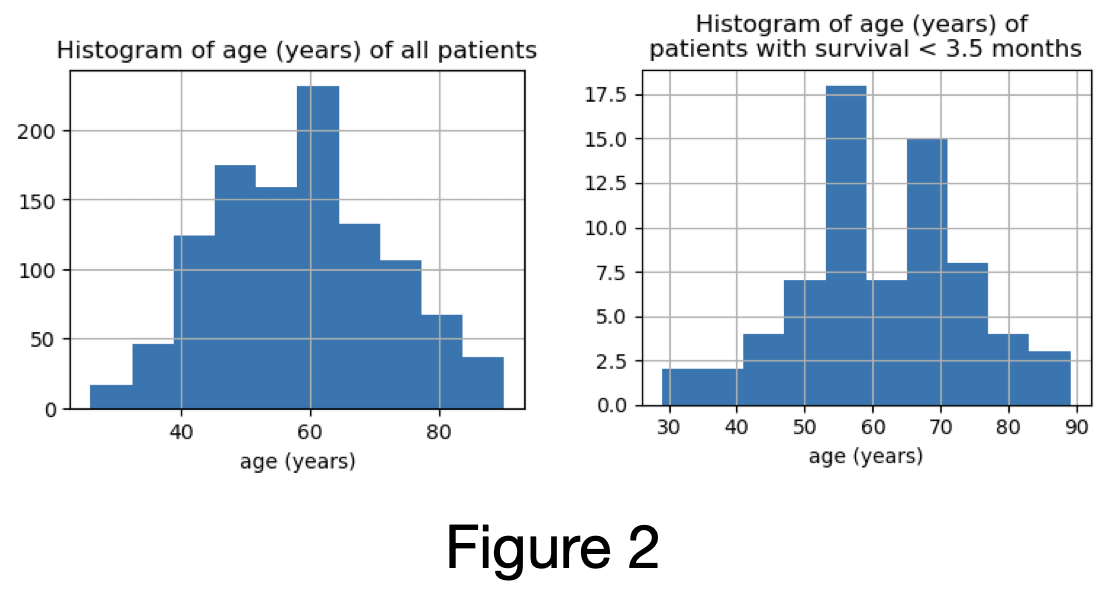 -->
- Has reported PAM50 subtype
- Has RNA, CNA and methylation data

- Feature data:
    - RNA (7,148 genes)
        - Remove genes that have zero expression in at least 20% (=121) of samples
        - When multiple Entrez IDs map to the same gene, use the sum
        - Restrict to largest connected component of genes in HPRD
    - CNA (8,763 genes)
        - When multiple Entrez IDs map to the same gene, select the more extreme value (i.e., in absolute value). If the absolute values are the same, select the loss.
        - Restrict to largest connected component of genes in HPRD
        - Translate from [-2, 2] -> [0, 4]
    - methylation (7,969 genes)        
        - Missing rate is at most 5.12% - used nearest-neighbor imputation computed in Python using the scikit-learn `KNNImputer` with default parameters except `weights=“distance”`.
        - When multiple Entrez IDs map to the same gene, select the max.
        - Restrict to largest connected component of genes in HPRD
- Network edgelists (derived from HPRD):
    - RNA edgelist (7,148 nodes and 27,498 edges)
    - CNA edgelist (8,763 nodes and 34,906 edges)
    - methylation edgelist (7,969 nodes and 31,112 edges)

In [7]:
rna = pd.read_csv(RNA_FNAME, header=0, index_col=0)
print(rna.shape)

display(rna.head(2))

(7148, 606)


,TCGA-E9-A295-01,TCGA-AR-A1AS-01,TCGA-AQ-A1H2-01,TCGA-A8-A08O-01,TCGA-BH-A1FJ-01,TCGA-JL-A3YX-01,TCGA-A7-A425-01,TCGA-AC-A2BM-01,TCGA-LL-A6FP-01,TCGA-A7-A26E-01,...,TCGA-A2-A1G0-01,TCGA-WT-AB41-01,TCGA-EW-A1P6-01,TCGA-XX-A89A-01,TCGA-A7-A4SD-01,TCGA-AC-A6IX-01,TCGA-AR-A24L-01,TCGA-BH-A42U-01,TCGA-AR-A24S-01,TCGA-BH-A0BC-01
ABCB8,910.2982,624.0432,422.2278,659.3773,836.3215,1202.2298,1264.0832,759.0133,2768.8172,560.3929,...,840.2367,1074.9211,769.4139,922.0595,597.0149,863.0025,451.0316,795.7087,606.1712,950.1840
SAT1,2727.0313,2731.2022,3701.4551,2259.7105,3085.1455,3915.4537,3230.3552,2042.0907,3258.4005,4837.8020,...,1728.7968,6252.3659,2843.2332,7392.0642,3602.4876,3878.9536,2552.8859,5193.3684,5891.7026,3594.8176


In [8]:
E_rna = pd.read_csv(E_RNA_FNAME, header=0)
display(E_rna.head(2))

G_rna = nx.from_pandas_edgelist(E_rna)
G_rna.name = 'rna'
print(G_rna)

,source,target
0,ABCB8,SAT1
1,SAT1,APLP1


Graph named 'rna' with 7148 nodes and 27498 edges


In [9]:
cna = pd.read_csv(CNA_FNAME, header=0, index_col=0)
print(cna.shape)

display(cna.head(2))

(8763, 606)


,TCGA-E9-A295-01,TCGA-AR-A1AS-01,TCGA-AQ-A1H2-01,TCGA-A8-A08O-01,TCGA-BH-A1FJ-01,TCGA-JL-A3YX-01,TCGA-A7-A425-01,TCGA-AC-A2BM-01,TCGA-LL-A6FP-01,TCGA-A7-A26E-01,...,TCGA-A2-A1G0-01,TCGA-WT-AB41-01,TCGA-EW-A1P6-01,TCGA-XX-A89A-01,TCGA-A7-A4SD-01,TCGA-AC-A6IX-01,TCGA-AR-A24L-01,TCGA-BH-A42U-01,TCGA-AR-A24S-01,TCGA-BH-A0BC-01
ABCB8,2,2,1,2,2,2,3,2,3,2,...,3,2,2,2,1,2,2,2,2,2
SAT1,2,2,1,1,2,1,2,1,2,2,...,3,2,2,1,1,2,2,2,2,2


In [10]:
E_cna = pd.read_csv(E_CNA_FNAME, header=0)
display(E_cna.head(2))

G_cna = nx.from_pandas_edgelist(E_cna)
G_cna.name = 'cna'
print(G_cna)

,source,target
0,ABCB8,SAT1
1,SAT1,APLP1


Graph named 'cna' with 8763 nodes and 34906 edges


# Initialize the Keeper

The `Keeper` can be instatiated with or without `outdir` - an output directory:

In [11]:
# uncomment to initialize Keeper with no output directory:
# keeper = nf.Keeper() 

# initializing Keeper with output directory:
keeper = nf.Keeper(outdir=OUT_DIR)

See the documentation for more details on initializing the `Keeper`.

# Load data into the Keeper

Currently, data is expected to be either in the form of a `numpy.ndarray` or `pandas.DataFrame`, or saved in a file that is loadable via `pandas.read_csv`, with observations as columns and features as rows.

Data can be loaded into the Keeper in two ways: 
    i. From a `numpy.ndarray` or `pandas.DataFrame` or
    ii. Directly from a file that is loadable via `pandas.read_csv`
    
Note: Future releases will handle various file types.

We add the data to `keeper` and provide a reference label, e.g., `'rna'`, to be able to refer to this particular data:

In [12]:
keeper.add_data(rna, 'rna')

The first time data is loaded into `keeper`, it sets the observation labels that must be consistent with any other feature data set, pairwise-observation distances data and pairwise-observation similarities data that will be added to `keeper` here on out. 

If instead the feature data was provided as a `numpy.ndarray`, observation labels default to `'X0', 'X1', ...`.

Within the `netflow` environment, this data can be specified by specifying the data set's reference label or __key__, e.g., `key='rna'`.

We see that `keeper` has updated the observation labels:

In [13]:
# uncomment to print out all observation labels:
# keeper.observation_labels

We can also upload the cna data:

In [14]:
keeper.add_data(cna, 'cna')

Similarly, we can add the graphs associated with the RNA data:

In [15]:
keeper.add_graph(G_rna, 'rna')

If we had pairwise-observation distances or similarities, we could add them to `keeper` in the same manner using the methods:

- `keeper.add_distance()`
- `keeper.add_similarity()`

Suppose we had some miscellaneous data, for example a list of genes of interest, that we wanted to store in the `Keeper`, this could be done as follows:

In [16]:
gene_list = ['SLC3A1', 'TIMM13', 'STYX', 'MUC6', 'TIMM17B', 'TNFSF18', 'TOMM7', 'TOMM40',
             'TRAPPC2L', 'AZU1', 'TUBB1', 'XCR1', 'VPS33B', 'XCL2', 'KNTC1']

In [17]:
keeper.add_misc(gene_list, 'my_gene_list')

# Load data into keeper at time of instatiation

Alternatively, you can specify any data, distances, similarities, graphs, or miscelaneous data to be loaded into the `Keeper` at the same time as it's initialized. For example, we initialize the `Keeper` and load the RNA and CNA feature data and their associated graphs in one call:

In [18]:
keeper = nf.Keeper(data={'rna': rna, 'cna': cna}, graphs={'rna': G_rna, 'cna': G_cna})

See the documentation on additional options for initializing and loading data into a `Keeper`.

# Load data into Keeper from file

Alternatively, we can load data, distances, similarities, and graphs directly from a file. 

Currently, file formats that can be loaded by `pandas.read_csv` are accepted. Future releases will offer additional file types.

We start by initializing a `Keeper` and then load the RNA and CNA data from file. The argument `label` is used to specify how the data is referenced in the `Keeper`.

In [19]:
keeper = nf.Keeper(outdir=OUT_DIR)

In [20]:
# Add RNA and CNA feature data:
keeper.load_data(RNA_FNAME, label='rna', header=0, index_col=0) 
keeper.load_data(CNA_FNAME, label='cna', header=0, index_col=0, dtype=float)

# uncomment to add methylation feature data:
# keeper.load_data(METH_FNAME, label='meth', header=0, index_col=0)

We next add the graphs associated with RNA and CNA. (See the documentation for more details and the expected edgelist format.)

In [21]:
keeper.load_graph(E_RNA_FNAME, label='rna')
keeper.load_graph(E_CNA_FNAME, label='cna')

# uncomment to add methylation graph:
# keeper.load_graph(E_METH_FNAME, label='meth')

Similarities and distances can be loaded from file into the `Keeper` in the same manner via:

- `keeper.load_distance()` or `keeper.load_stacked_distance()`
- `keeper.load_similarity()` or `keeper.load_stacked_similarity()`

See the documentaion for more details.

# Extract data from the Keeper

We can extract the data in the form of a `pandas.DataFrame` as follows:

In [22]:
df = keeper.data['rna'].to_frame()
df.head(3)

,TCGA-E9-A295-01,TCGA-AR-A1AS-01,TCGA-AQ-A1H2-01,TCGA-A8-A08O-01,TCGA-BH-A1FJ-01,TCGA-JL-A3YX-01,TCGA-A7-A425-01,TCGA-AC-A2BM-01,TCGA-LL-A6FP-01,TCGA-A7-A26E-01,...,TCGA-A2-A1G0-01,TCGA-WT-AB41-01,TCGA-EW-A1P6-01,TCGA-XX-A89A-01,TCGA-A7-A4SD-01,TCGA-AC-A6IX-01,TCGA-AR-A24L-01,TCGA-BH-A42U-01,TCGA-AR-A24S-01,TCGA-BH-A0BC-01
ABCB8,910.2982,624.0432,422.2278,659.3773,836.3215,1202.2298,1264.0832,759.0133,2768.8172,560.3929,...,840.2367,1074.9211,769.4139,922.0595,597.0149,863.0025,451.0316,795.7087,606.1712,950.1840
SAT1,2727.0313,2731.2022,3701.4551,2259.7105,3085.1455,3915.4537,3230.3552,2042.0907,3258.4005,4837.8020,...,1728.7968,6252.3659,2843.2332,7392.0642,3602.4876,3878.9536,2552.8859,5193.3684,5891.7026,3594.8176
ABCF3,1310.1533,1381.3597,1413.9488,1078.8295,992.8420,1273.1496,1344.0976,1256.8570,2183.8038,1067.4277,...,1055.8843,2185.3312,1145.1250,1031.6486,1705.9701,1292.1338,924.5234,1223.4741,1003.6413,1278.0836


Similarly, this can be done for any key in the distance or similarity keeper in the form:

- `keeper.distances[key].to_frame()`
- `keeper.similarities[key].to_frame()`

Next, we demonstrate how to get a graph that has been stored in `keeper`, keyed by its reference label:

In [23]:
G = keeper.graphs['rna']
print(G)

Graph named 'rna' with 7148 nodes and 27498 edges


Similarly, we can access miscellaneous data stored in `keeper`:

In [24]:
# first we add the gene list to the keeper:
keeper.add_misc(gene_list, 'my_gene_list')

In [25]:
# and to access the gene list:
keeper.misc['my_gene_list']

['SLC3A1',
 'TIMM13',
 'STYX',
 'MUC6',
 'TIMM17B',
 'TNFSF18',
 'TOMM7',
 'TOMM40',
 'TRAPPC2L',
 'AZU1',
 'TUBB1',
 'XCR1',
 'VPS33B',
 'XCL2',
 'KNTC1']

# Save data from the Keeper

Data can be saved from:
- `keeper.data` via `keeper.save_data()`
- `keeper.distances` via `keeper.save_distance()`
- `keeper.similarities` via `keeper.save_similarity()`
- `keeper.misc` (if it is a `pandas.DataFrame`) via `keeper.save_misc()`

Currently, it is saved using `pandas.to_csv`. Future releases will provide additional formats for saving data.

In order to save data, `keeper` must have the attribute `outdir` defined.

The data is then saved to a file named `{outdir}/{data_type}_{label}.{file_format}` where
- `outdir` : The keeper's output directory: `keeper.outdir`.
- `data_type` : This is one of {'data', 'distance', 'similarity', 'misc'}, depending on which method is called to save the data.
- `label` : This is reference label for the data in the keeper that should be saved, specified by the user.
- `file_format` This is the file extension, provided by the user (default = 'txt'). 

See the documentation for more details.

For example, to save the RNA data to the specified output directory, you would call:

`keeper.save_data('rna')`

# Extract Keeper subset

You can a new `Keeper` instance with a subset of the observations from the `keeper`. 

Caution should be taken for the resulting `misc` and `graphs` keepers, as they are maintained independent of the observations. You can select if the misc and graphs should be copied into the the new subset Keeper, as is.  

You can also specify the output directory `outdir` for the new keeper subset. Default is `None`.

For example, we can extract a subset of `keeper` with the first 3 observations, using `keep_misc=True` and `keep_graphs=True` to keep a copy of miscellaneous data and the graphs. Additionally, we use `outdir` to specify the output directory we want for this subset of observations

In [26]:
outdir_sub = OUT_DIR.parent / (OUT_DIR.name + '_sub')

keeper_sub = keeper.subset(keeper.observation_labels[:10], 
                           keep_misc=True, keep_graphs=True,
                           outdir=outdir_sub)

netflow.keepers.keeper: 07/24/2025 11:54:22  AM | MSG | keeper:__init__:1157 | >>> Created directory               
/Users/renae12/Documents/MSKCC/dev/netflow/docs/source/tutorial/notebooks/example_data/results_netflow_breast_tcga_
sub.

# Extract data subset

You can extract a subset of observations and features for any data stored in the data-keeper as a `pandas.DataFrame`: 

In [27]:
rna_sub = keeper.data['rna'].subset(observations=keeper.observation_labels[:3],
                                    features=gene_list[:5])
rna_sub

,TCGA-E9-A295-01,TCGA-AR-A1AS-01,TCGA-AQ-A1H2-01
SLC3A1,4.8292,0.0000,3.1360
TIMM13,1078.3533,992.7960,708.2288
STYX,829.6511,542.0982,403.1611
MUC6,1.4488,130.1216,0.0000
TIMM17B,827.7194,573.1652,739.5886


Similarly, you can extract distances (or similarities) between a subset of observations as a `pandas.DataFrame`. We'll first add a distance to the keeper to demonstrate this:

In [28]:
from scipy.spatial.distance import cdist

In [29]:
rna_euc = pd.DataFrame(data=cdist(rna.T, rna.T, metric='euclidean'),
                       index=rna.columns.copy(), columns=rna.columns.copy())
keeper.add_distance(rna_euc, 'rna_euc')

In [30]:
keeper.distances['rna_euc'].subset(keeper.observation_labels[:3])

,TCGA-E9-A295-01,TCGA-AR-A1AS-01,TCGA-AQ-A1H2-01
TCGA-E9-A295-01,0.000000,351149.925916,392258.653370
TCGA-AR-A1AS-01,351149.925916,0.000000,382107.888105
TCGA-AQ-A1H2-01,392258.653370,382107.888105,0.000000


The same can be done for a similarity stored in `keeper` using `keeper.similarities` in place of `keeper.distances`.

# Iterating through feature data, distances or similarities

Before demonstrating how to iterate through the data, we review some of the `Keeper` class properties in a bit more detail: 

When we instatiate a `Keeper` object: `keeper = netflow.Keeper()`, 
the `keeper` is initialized with an instance of the `DataKeeper` class assigned as `keeper.data` and two instances of the `DistanceKeeper` class assigned as `keeper.distances` and `keeper.similarities`. Data is added to the `DataKeeper` and `DistanceKeeper` with a reference key which may then be accessed in the same manner as retrieving a value from a `dict`. However, the `DataKeeper` and `DistanceKeeper` maintain a bit more information than just the data itself to regulate observation (and feature) properties. Therefore, keyed-accessing data from `DataKeeper` or `DistanceKeeper` returns an instance of `DataView` or `DistanceView`, respectively (instead of the original input data). 

For example: `x = keeper.data['rna']`   
Here, `x` is an instance of the `DataView` class.   
The RNA data itself (as a `numpy.ndarray`) can be accessed via `x.data`.    
And previously, we demonstrated how to extract the data as a `pandas.DataFrame`: `x.to_frame()`. (The `.to_frame()` property is actually a method of the `DataView` (and `DistanceView`) class.)

You can iterate over the data stored in a `DataKeeper` and `DistanceKeeper`, which yields an instance of `DataView` and `DistanceView`, repectively, at each iteration.

Therefore, you can iterate over the feature data, distances and similarities. The process is the same for each type of store data, so we demonstrate this on the feature data.

Here we iterate through all the feature data and print the keyed-label:

In [31]:
for dd in keeper.data:
    print(dd.label)

rna
cna


Here we iterate through all the feature data and print out the number of features:

In [32]:
for dd in keeper.data:
    print(dd.num_features)

7148
8763


Here we iterate through all the feature data and print out the first 4 feature labels:

In [33]:
for dd in keeper.data:
    print(dd.feature_labels[:4])

['ABCB8', 'SAT1', 'ABCF3', 'ARF1']
['ABCB8', 'SAT1', 'ABCF3', 'ARF1']


Here we iterate through all the feature data and print out the stored data for the first 3 observations and first 4 features:

In [34]:
for dd in keeper.data:
    print(dd.data[:4, :3])

[[  910.2982   624.0432   422.2278]
 [ 2727.0313  2731.2022  3701.4551]
 [ 1310.1533  1381.3597  1413.9488]
 [15602.5595 17668.1675 10149.0216]]
[[2. 2. 1.]
 [2. 2. 1.]
 [2. 3. 2.]
 [3. 3. 2.]]


# Membership

You can check if data is in `keeper.data`, `keeper.distances`, or `keeper.similarities` by its key.

For example, we next check if the RNA feature data is in `keeper.data`

In [35]:
'rna' in keeper.data

True